In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['font.family'] = 'arial'
mpl.rcParams['font.size'] = 14

from scipy import signal
from sklearn.linear_model import LinearRegression

def load(path1, path2):
    data_pv = pd.read_csv(path1,
                        compression='gzip',
                        skiprows=6,
                        delimiter='\t',
                        header=None)
    data_or = pd.read_csv(path2,
                        compression='gzip',
                        skiprows=1,
                        delimiter='\t',
                        header=None)


    pv_timestamp = data_pv[0][1:].to_numpy()
    pv_fs = int(1/(pv_timestamp[1] - pv_timestamp[0]))

    pv_c = data_pv[1][1:].to_numpy()
    pv_b = data_pv[2][1:].to_numpy()
    pv_tl = data_pv[3][1:].to_numpy()
    pv_tr = data_pv[4][1:].to_numpy()

    or_timestamp = ((data_or[0].to_numpy().astype(int))//10)*0.01
    or_fs = int(1/(or_timestamp[1] - or_timestamp[0]))

    or_y = data_or[1].to_numpy()
    or_p = data_or[2].to_numpy()
    or_r = data_or[3].to_numpy()

    return pv_timestamp, pv_fs, pv_c, pv_b, pv_tl, pv_tr, or_timestamp, or_fs, or_y, or_p, or_r

def despike(arr, window_size, threshold):
    pad_size = window_size // 2
    arr_padded = np.pad(arr, pad_size, mode='reflect')
    arr_rolled = np.convolve(arr_padded, np.ones(window_size)/window_size, mode='same')
    spikes = np.abs(arr-arr_rolled[pad_size:-pad_size]) > threshold
    arr_despiked = np.copy(arr)
    arr_despiked[spikes] = arr_rolled[pad_size:-pad_size][spikes]
    return arr_despiked

def detrend(arr):
    x = np.arange(len(arr)).reshape(-1, 1)
    model = LinearRegression().fit(x, arr)
    trend = model.predict(x)
    detrended = arr - trend.flatten()
    return detrended

def normalize(arr):
    return 2*((arr-np.min(arr))/(np.max(arr)-np.min(arr)))-1

def normalize_all_pv(c, b, tl, tr):
    return normalize(c), normalize(b), normalize(tl), normalize(tr)

def normalize_all_or(y, p, r):
    return normalize(y), normalize(p), normalize(r)

def plot_filtered_pv(timestamp, fs, c, b, tl, tr):
    sos = signal.butter(3, [0.1, 30], btype='bandpass', fs=fs, output='sos')

    c_f = signal.sosfiltfilt(sos, c, padlen=100)
    b_f = signal.sosfiltfilt(sos, b, padlen=100)
    tl_f = signal.sosfiltfilt(sos, tl, padlen=100)
    tr_f = signal.sosfiltfilt(sos, tr, padlen=100)

    fig = plt.figure(figsize=[10, 5])
    ax = fig.add_subplot()
    ax.plot(timestamp, c_f)
    ax.plot(timestamp, b_f)
    ax.plot(timestamp, tl_f)
    ax.plot(timestamp, tr_f)

    return c_f, b_f, tl_f, tr_f

In [2]:
path_pv1 = '../dataset/pv/20230309/continuous_1.gz'
path_or1 = '../dataset/orientation/20230309/continuous_1.gz'
path_pv2 = '../dataset/pv/20230309/continuous_2.gz'
path_or2 = '../dataset/orientation/20230309/continuous_2.gz'

pv_timestamp1, pv_fs1, c1, b1, tl1, tr1, or_timestamp1, or_fs1, y1, p1, r1 = load(path_pv1, path_or1)
pv_timestamp2, pv_fs2, c2, b2, tl2, tr2, or_timestamp2, or_fs2, y2, p2, r2 = load(path_pv2, path_or2)

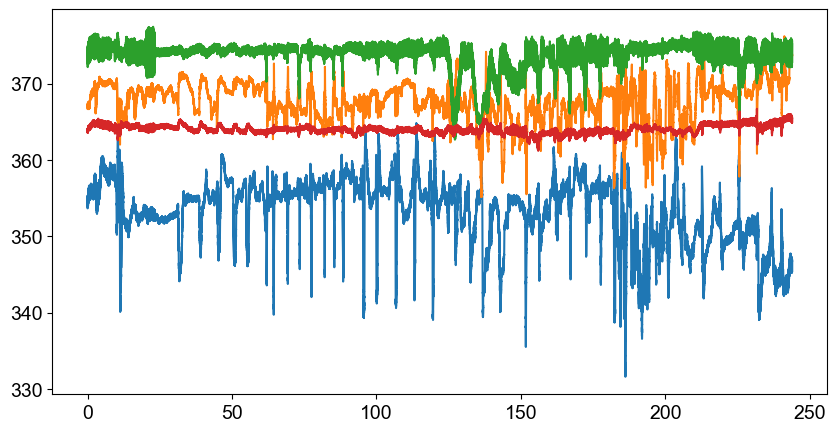

In [3]:
fig = plt.figure(figsize=[10, 5])
ax = fig.add_subplot()
ax.plot(pv_timestamp1, c1)
ax.plot(pv_timestamp1, b1)
ax.plot(pv_timestamp1, tl1)
ax.plot(pv_timestamp1, tr1)

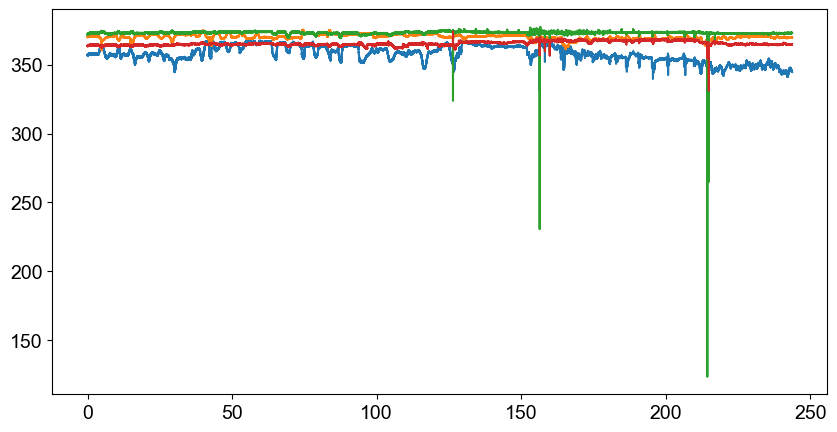

In [4]:
fig = plt.figure(figsize=[10, 5])
ax = fig.add_subplot()
ax.plot(pv_timestamp2, c2)
ax.plot(pv_timestamp2, b2)
ax.plot(pv_timestamp2, tl2)
ax.plot(pv_timestamp2, tr2)

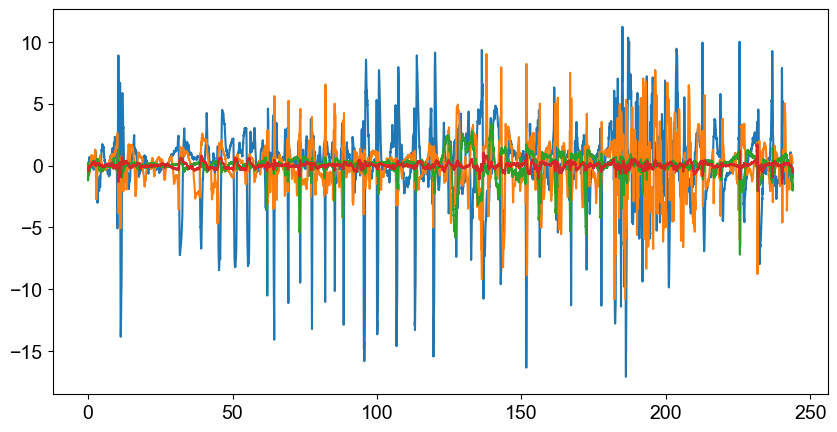

In [5]:
c_f1, b_f1, tl_f1, tr_f1 = plot_filtered_pv(pv_timestamp1, pv_fs1, c1, b1, tl1, tr1)

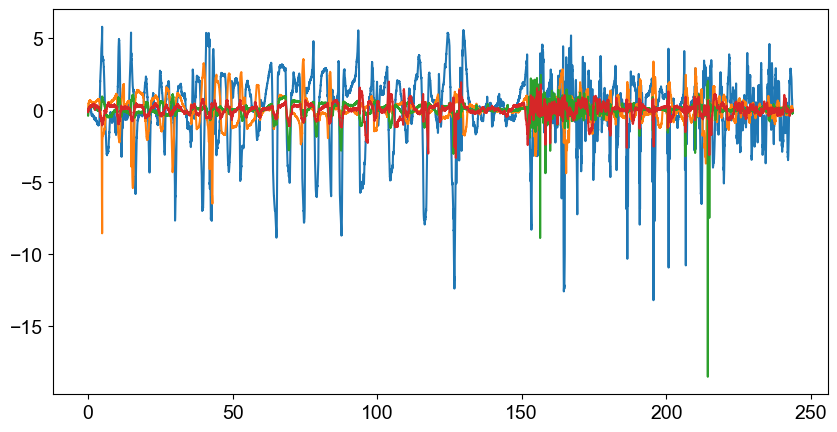

In [6]:
c_f2, b_f2, tl_f2, tr_f2 = plot_filtered_pv(pv_timestamp2, pv_fs2, c2, b2, tl2, tr2)

(200.0, 220.0)

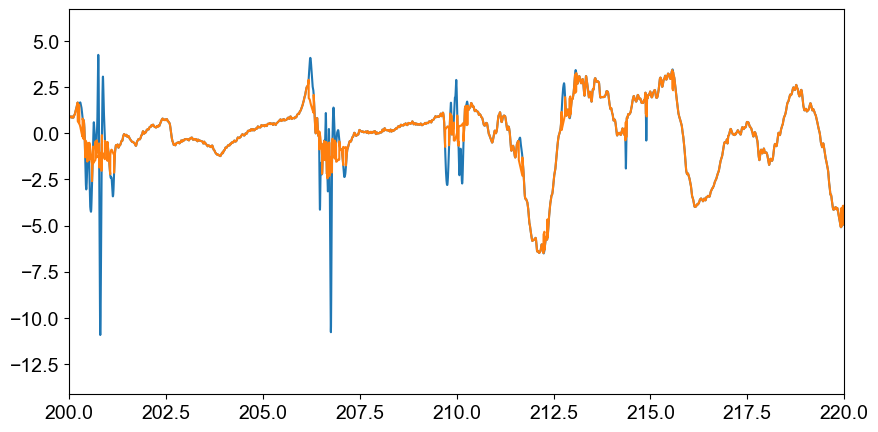

In [7]:
# for 20230309/continuous_2

c_f_ds2 = despike(c_f2, 500, 1)
tl_f_ds2 = despike(tl_f2, 500, 1)
tr_f_ds2 = despike(tr_f2, 500, 1)

fig = plt.figure(figsize=[10, 5])
ax = fig.add_subplot()
ax.plot(pv_timestamp2, c_f2)
ax.plot(pv_timestamp2, c_f_ds2)
ax.set_xlim(200, 220)

(0.0, 240.0)

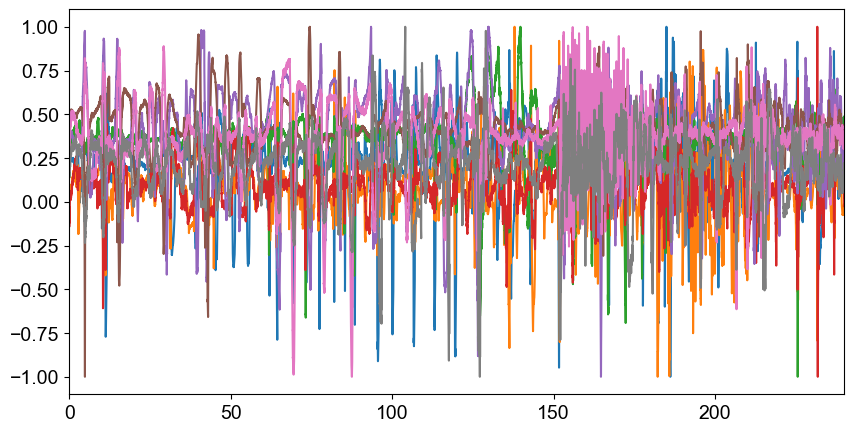

In [8]:
c_n1, b_n1, tl_n1, tr_n1 = normalize_all_pv(c_f1, b_f1, tl_f1, tr_f1)
c_n2, b_n2, tl_n2, tr_n2 = normalize_all_pv(c_f_ds2, b_f2, tl_f_ds2, tr_f_ds2)

fig = plt.figure(figsize=[10, 5])
ax = fig.add_subplot()
ax.plot(pv_timestamp1, c_n1)
ax.plot(pv_timestamp1, b_n1)
ax.plot(pv_timestamp1, tl_n1)
ax.plot(pv_timestamp1, tr_n1)

ax.plot(pv_timestamp2, c_n2)
ax.plot(pv_timestamp2, b_n2)
ax.plot(pv_timestamp2, tl_n2)
ax.plot(pv_timestamp2, tr_n2)
ax.set_xlim(0, 240)

In [19]:
np.savetxt('../results/fig1/pv_sample.txt', np.vstack((pv_timestamp1, c_n1, b_n1, tl_n1, tr_n1)).T)

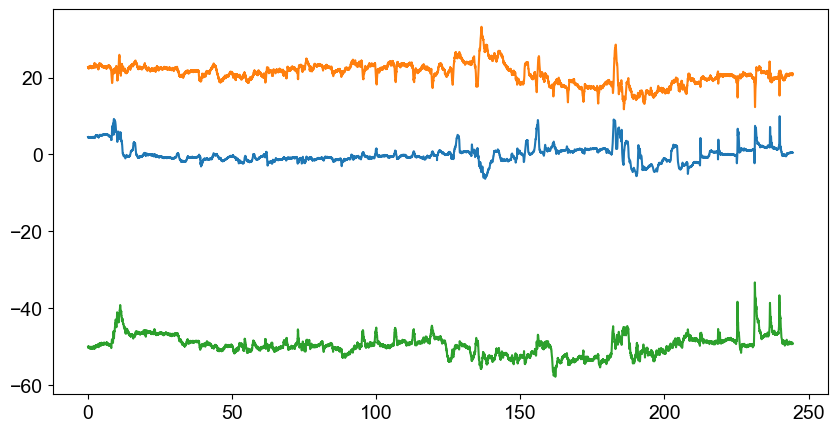

In [21]:
WINDOW = 100
THRESHOLD = 10

y_ds1 = despike(y1, WINDOW, THRESHOLD)
y_dt1 = detrend(y_ds1)

fig = plt.figure(figsize=[10, 5])
ax1 = fig.add_subplot()
ax1.plot(or_timestamp1, y_dt1)
ax1.plot(or_timestamp1, p1)
ax1.plot(or_timestamp1, r1)

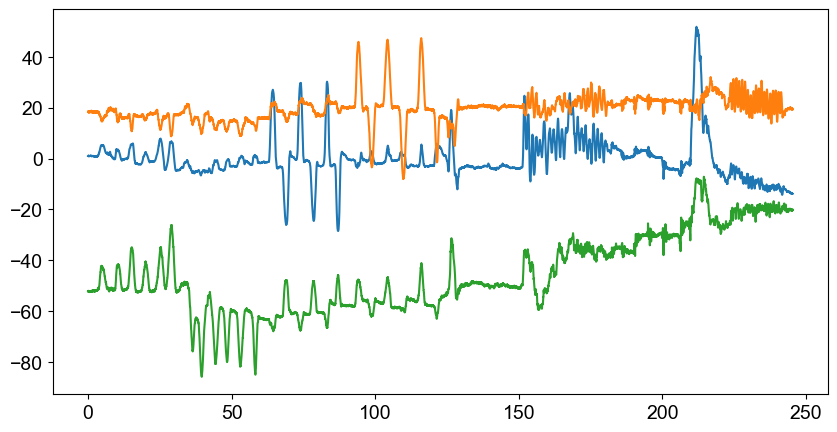

In [22]:
y2 = np.where(y2 > 180, y2 - 360, y2) # depend on the condition

y_ds2 = despike(y2, WINDOW, THRESHOLD)
y_dt2 = detrend(y_ds2)

fig = plt.figure(figsize=[10, 5])
ax1 = fig.add_subplot()
ax1.plot(or_timestamp2, y_dt2)
ax1.plot(or_timestamp2, p2)
ax1.plot(or_timestamp2, r2)

In [23]:
y_n1, p_n1, r_n1 = normalize_all_or(y_dt1, p1, r1)
y_n2, p_n2, r_n2 = normalize_all_or(y_dt2, p2, r2)

In [25]:
np.savetxt('../results/fig1/or_sample.txt', np.vstack((or_timestamp1, y_n1, p_n1, r_n1)).T)

FOR 20230309/continuous_1

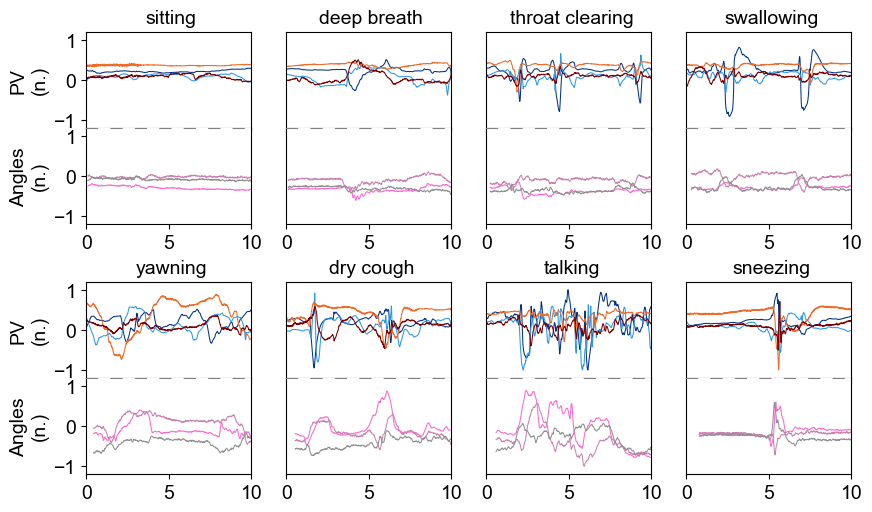

In [63]:
left_borders = np.array([20, 35, 60, 93, 125, 150, 180, 220])
right_borders = left_borders+10

labels = ['sitting',
          'deep breath',
          'throat clearing',
          'swallowing',
          'yawning',
          'dry cough',
          'talking',
          'sneezing']

plt.rc('lines', lw=0.75)
fig = plt.figure(figsize=[8, 5])
subfigs = fig.subfigures(nrows=2, ncols=4, wspace=0)
font = {'family': 'arial',
        'size': 14}
pv_color = ['#003388', '#2a97e9', '#f06a28', '#7e0000']
or_color = ['#ff66d0', '#ca82b0', '#909090']

isFirstInItsRow = False

for ii, (l, r, subfig) in enumerate(zip(left_borders, right_borders, subfigs.flatten())):
    if ii % 4 == 0: 
        isFirstInItsRow = True
    else:
        isFirstInItsRow = False
        
    sample_pv_ind = np.arange(l*pv_fs1, r*pv_fs1)
    sample_or_ind = np.arange(l*or_fs1, r*or_fs1)
    (ax1, ax2) = subfig.subplots(nrows=2, sharex=True)
    ax2.spines['top'].set_linestyle((0, (10, 12)))
    ax2.spines['top'].set_color('gray')
    
    ax1.plot(pv_timestamp1[sample_pv_ind], c_n1[sample_pv_ind])
    ax1.plot(pv_timestamp1[sample_pv_ind], b_n1[sample_pv_ind])
    ax1.plot(pv_timestamp1[sample_pv_ind], tl_n1[sample_pv_ind])
    ax1.plot(pv_timestamp1[sample_pv_ind], tr_n1[sample_pv_ind])
    ax1.set_ylim([-1.2, 1.2])
    if isFirstInItsRow:
        ax1.set_ylabel('PV\n(n.)', fontdict=font)
        # ax1.set_yticks([330, 355, 380])
        # ax1.set_yticklabels([0, 25, 50], fontdict=font)
    else:
        ax1.set_yticks([])
    for jj, line in enumerate(ax1.get_lines()):
        line.set_color(pv_color[jj])

    ax2.plot(or_timestamp1[sample_or_ind], y_n1[sample_or_ind])
    ax2.plot(or_timestamp1[sample_or_ind], p_n1[sample_or_ind])
    ax2.plot(or_timestamp1[sample_or_ind], r_n1[sample_or_ind])
    ax2.set_ylim([-1.2, 1.2])
    if isFirstInItsRow:
        ax2.set_ylabel('Angles\n(n.)', fontdict=font)
        # ax2.set_yticks([-60, 0, 60])
        # ax2.set_yticklabels([-60, 0, 60], fontdict=font)
    else:
        ax2.set_yticks([])
    ax2.set_xlim([l, r])
    ax2.set_xticks([l, (l+r)/2, r])
    ax2.set_xticklabels([0, 5, 10], fontdict=font)
    # ax2.set_xlabel('Time (s)', fontdict=font)
    for jj, line in enumerate(ax2.get_lines()):
        line.set_color(or_color[jj])
    
    subfig.suptitle(labels[ii], x=0.55, y=0.97, ha='center', fontproperties=font)
    plt.subplots_adjust(right=0.95,
                        hspace=0)        

# plt.savefig('../results/fig4/1.png', dpi=600,
#             bbox_inches='tight')
plt.show()

FOR 20230309/continuous_2

In [153]:
path_pv = '../dataset/pv/20230309/continuous_2.gz'
path_or = '../dataset/orientation/20230309/continuous_2.gz'
data_pv = pd.read_csv(path_pv,
                      compression='gzip',
                      skiprows=6,
                      delimiter='\t',
                      header=None)
data_or = pd.read_csv(path_or,
                      compression='gzip',
                      skiprows=1,
                      delimiter='\t',
                      header=None)

pv_timestamp = data_pv[0][1:].to_numpy()
pv_fs = int(1/(pv_timestamp[1] - pv_timestamp[0]))

pv_c = data_pv[1][1:].to_numpy()
pv_b = data_pv[2][1:].to_numpy()
pv_tl = data_pv[3][1:].to_numpy()
pv_tr = data_pv[4][1:].to_numpy()

or_timestamp = ((data_or[0].to_numpy().astype(int))//10)*0.01
or_fs = int(1/(or_timestamp[1] - or_timestamp[0]))

or_y = data_or[1].to_numpy()
or_p = data_or[2].to_numpy()
or_r = data_or[3].to_numpy()

or_y = np.where(or_y > 180, or_y - 360, or_y) # depend on the condition

sos = signal.butter(3, [0.1, 30], btype='bandpass', fs=pv_fs, output='sos')

pv_c_f = signal.sosfiltfilt(sos, pv_c, padlen=100)
pv_b_f = signal.sosfiltfilt(sos, pv_b, padlen=100)
pv_tl_f = signal.sosfiltfilt(sos, pv_tl, padlen=100)
pv_tr_f = signal.sosfiltfilt(sos, pv_tr, padlen=100)

pv_c_f_ds = despike(pv_c_f, 500, 1)
pv_tl_f_ds = despike(pv_tl_f, 500, 1)
pv_tr_f_ds = despike(pv_tr_f, 500, 1)

pv_c_n = normalize(pv_c_f_ds)
pv_b_n = normalize(pv_b_f)
pv_tl_n = normalize(pv_tl_f_ds)
pv_tr_n = normalize(pv_tr_f_ds)

or_y_ds = despike(or_y, WINDOW, THRESHOLD)
or_y_dt = detrend(or_y_ds)

or_y_n = normalize(or_y_dt)
or_p_n = normalize(or_p)
or_r_n = normalize(or_r)

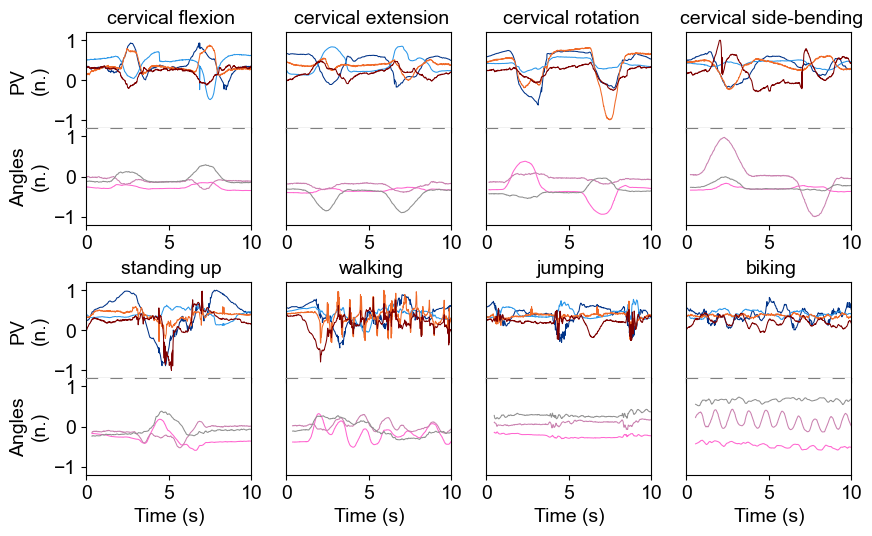

In [160]:
left_borders = np.array([8, 46, 62, 102, 122, 150, 182, 223])
right_borders = left_borders+10

labels = ['cervical flexion',
          'cervical extension',
          'cervical rotation',
          'cervical side-bending',
          'standing up',
          'walking',
          'jumping',
          'biking']

plt.rc('lines', lw=0.75)
fig = plt.figure(figsize=[8, 5])
subfigs = fig.subfigures(nrows=2, ncols=4, wspace=0)
font = {'family': 'arial',
        'size': 14}
pv_color = ['#003388', '#2a97e9', '#f06a28', '#7e0000']
or_color = ['#ff66d0', '#ca82b0', '#909090']

isFirstInItsRow = False
isLastInItsColumn = False

for ii, (l, r, subfig) in enumerate(zip(left_borders, right_borders, subfigs.flatten())):
    if ii % 4 == 0: 
        isFirstInItsRow = True
    else:
        isFirstInItsRow = False
    
    if ii // 4 != 0:
        isLastInItsColumn = True
    else:
        isLastInItsColumn = False
        
    sample_pv_ind = np.arange(l*pv_fs, r*pv_fs)
    sample_or_ind = np.arange(l*or_fs, r*or_fs)
    (ax1, ax2) = subfig.subplots(nrows=2, sharex=True)
    ax2.spines['top'].set_linestyle((0, (10, 12)))
    ax2.spines['top'].set_color('gray')
    
    ax1.plot(pv_timestamp[sample_pv_ind], pv_c_n[sample_pv_ind])
    ax1.plot(pv_timestamp[sample_pv_ind], pv_b_n[sample_pv_ind])
    ax1.plot(pv_timestamp[sample_pv_ind], pv_tl_n[sample_pv_ind])
    ax1.plot(pv_timestamp[sample_pv_ind], pv_tr_n[sample_pv_ind])
    ax1.set_ylim([-1.2, 1.2])
    if isFirstInItsRow:
        ax1.set_ylabel('PV\n(n.)', fontdict=font)
        # ax1.set_yticks([330, 355, 380])
        # ax1.set_yticklabels([0, 25, 50], fontdict=font)
    else:
        ax1.set_yticks([])
    for i, line in enumerate(ax1.get_lines()):
        line.set_color(pv_color[i])
    
    ax2.plot(or_timestamp[sample_or_ind], or_y_n[sample_or_ind])
    ax2.plot(or_timestamp[sample_or_ind], or_p_n[sample_or_ind])
    ax2.plot(or_timestamp[sample_or_ind], or_r_n[sample_or_ind])
    ax2.set_ylim([-1.2, 1.2])
    if isFirstInItsRow:
        ax2.set_ylabel('Angles\n(n.)', fontdict=font)
        # ax2.set_yticks([-60, 0, 60])
        # ax2.set_yticklabels([-60, 0, 60], fontdict=font)
    else:
        ax2.set_yticks([])
    ax2.set_xlim([l, r])
    ax2.set_xticks([l, (l+r)/2, r])
    ax2.set_xticklabels([0, 5, 10], fontdict=font)
    if isLastInItsColumn:
        ax2.set_xlabel('Time (s)', fontdict=font)
    for i, line in enumerate(ax2.get_lines()):
        line.set_color(or_color[i])

    subfig.suptitle(labels[ii], x=0.55, y=0.97, ha='center', fontproperties=font)
    plt.subplots_adjust(right=0.95,
                        hspace=0)      
plt.savefig('../results/fig4/2.png', dpi=600,
            bbox_inches='tight')
plt.show()

CONTINUOUS PLOT

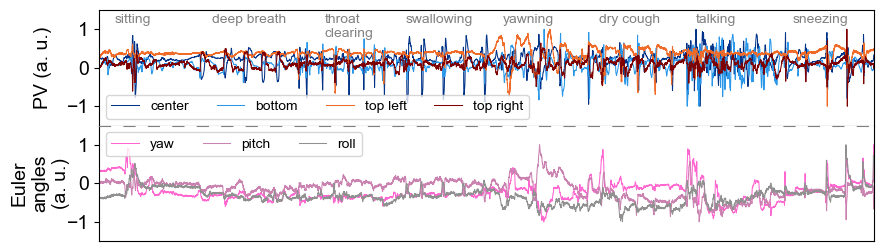

In [78]:
fontlegend = {'size': 10,
              'family': 'arial'}

fig = plt.figure(figsize=[10, 3])
(ax1, ax2) = fig.subplots(nrows=2)
ax2.spines['top'].set_linestyle((0, (10, 12)))
ax2.spines['top'].set_color('gray')    

ax1.plot(pv_timestamp1, c_n1, label='center')
ax1.plot(pv_timestamp1, b_n1, label='bottom')
ax1.plot(pv_timestamp1, tl_n1, label='top left')
ax1.plot(pv_timestamp1, tr_n1, label='top right')

ax1.set_xlabel('Time (s)', )
ax1.set_xlim(0, 240)
ax1.set_xticks([])

ax1.set_ylabel('PV (a. u.)', labelpad=11, fontdict=font)
ax1.set_ylim([-1.5, 1.5])
# ax1.set_yticks([330, 355, 380])
# ax1.set_yticklabels([0, 25, 50], fontdict=font)

for ii, line in enumerate(ax1.get_lines()):
    line.set_color(pv_color[ii])
ax1.legend(loc='lower left',
           ncol=len(ax1.get_lines()),
           frameon=True,
           prop=fontlegend)

ax1.text(5, 1.15, 'sitting', fontfamily='arial', size=10, color='gray')
ax1.text(35, 1.15, 'deep breath', fontfamily='arial', size=10, color='gray')
ax1.text(70, 0.8, 'throat\nclearing', fontfamily='arial', size=10, color='gray')
ax1.text(95, 1.15, 'swallowing', fontfamily='arial', size=10, color='gray')
ax1.text(125, 1.15, 'yawning', fontfamily='arial', size=10, color='gray')
ax1.text(155, 1.15, 'dry cough', fontfamily='arial', size=10, color='gray')
ax1.text(185, 1.15, 'talking', fontfamily='arial', size=10, color='gray')
ax1.text(215, 1.15, 'sneezing', fontfamily='arial', size=10, color='gray')

ax2.plot(or_timestamp1, y_n1, label='yaw')
ax2.plot(or_timestamp1, p_n1, label='pitch')
ax2.plot(or_timestamp1, r_n1, label='roll')

# ax2.set_xlabel('Time (s)', fontdict=font)
ax2.set_xlim(0, 240)
ax2.set_xticks([])
# ax2.set_xticks(np.arange(0, 280, 40))
# ax2.set_xticklabels(np.arange(0, 280, 40), fontdict=font)

ax2.set_ylabel('Euler\nangles\n(a. u.)', labelpad=-2, fontdict=font)
ax2.set_ylim([-1.5, 1.5])
# ax2.set_yticks([-60, 0, 60])
# ax2.set_yticklabels([-60, 0, 60], fontdict=font)

for ii, line in enumerate(ax2.get_lines()):
    line.set_color(or_color[ii])
ax2.legend(loc='upper left',
           ncol=len(ax2.get_lines()),
           frameon=True,
           prop=fontlegend)

plt.subplots_adjust(hspace=0)
plt.savefig('../results/fig4/continuous1.png', dpi=600,
            bbox_inches='tight')

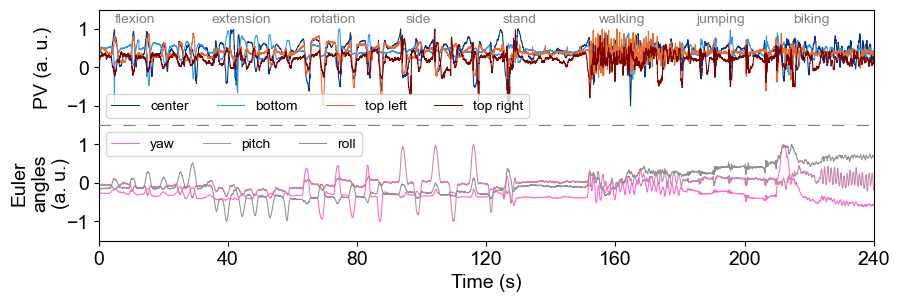

In [77]:
fontlegend = {'size': 10,
              'family': 'arial'}

fig = plt.figure(figsize=[10, 3])
(ax1, ax2) = fig.subplots(nrows=2)
ax2.spines['top'].set_linestyle((0, (10, 12)))
ax2.spines['top'].set_color('gray')    

ax1.plot(pv_timestamp2, c_n2, label='center')
ax1.plot(pv_timestamp2, b_n2, label='bottom')
ax1.plot(pv_timestamp2, tl_n2, label='top left')
ax1.plot(pv_timestamp2, tr_n2, label='top right')

ax1.set_xlabel('Time (s)', fontdict=font)
ax1.set_xlim(0, 240)
ax1.set_xticks([])

ax1.set_ylabel('PV (a. u.)', labelpad=11, fontdict=font)
ax1.set_ylim([-1.5, 1.5])
# ax1.set_yticks([330, 355, 380])
# ax1.set_yticklabels([0, 25, 50], fontdict=font)

for ii, line in enumerate(ax1.get_lines()):
    line.set_color(pv_color[ii])
ax1.legend(loc='lower left',
           ncol=len(ax1.get_lines()),
           frameon=True,
           prop=fontlegend)

ax1.text(5, 1.15, 'flexion', fontfamily='arial', size=10, color='gray')
ax1.text(35, 1.15, 'extension', fontfamily='arial', size=10, color='gray')
ax1.text(65, 1.15, 'rotation', fontfamily='arial', size=10, color='gray')
ax1.text(95, 1.15, 'side', fontfamily='arial', size=10, color='gray')
ax1.text(125, 1.15, 'stand', fontfamily='arial', size=10, color='gray')
ax1.text(155, 1.15, 'walking', fontfamily='arial', size=10, color='gray')
ax1.text(185, 1.15, 'jumping', fontfamily='arial', size=10, color='gray')
ax1.text(215, 1.15, 'biking', fontfamily='arial', size=10, color='gray')

ax2.plot(or_timestamp2, y_n2, label='yaw')
ax2.plot(or_timestamp2, p_n2, label='pitch')
ax2.plot(or_timestamp2, r_n2, label='roll')

ax2.set_xlabel('Time (s)', fontdict=font)
ax2.set_xlim(0, 240)
ax2.set_xticks(np.arange(0, 280, 40))
ax2.set_xticklabels(np.arange(0, 280, 40), fontdict=font)

ax2.set_ylabel('Euler\nangles\n(a. u.)', labelpad=-2, fontdict=font)
ax2.set_ylim([-1.5, 1.5])
# ax2.set_yticks([-60, 0, 60])
# ax2.set_yticklabels([-60, 0, 60], fontdict=font)

for ii, line in enumerate(ax2.get_lines()):
    line.set_color(or_color[ii])
ax2.legend(loc='upper left',
           ncol=len(ax2.get_lines()),
           frameon=True,
           prop=fontlegend)

plt.subplots_adjust(hspace=0)
plt.savefig('../results/fig4/continuous2.png', dpi=600,
            bbox_inches='tight')